<h2 style="color:lightblue">Regression Analysis for Predicting Home Prices in Bangalore: A Data Science Project</h2>

- I used a dataset that you can find here: https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

<h4 style="color:lightblue">IMPORTS</h4>

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import pickle
import json

<h3 style="color:lightblue"> LOADING THE DATASET </h3>

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.shape

(13320, 9)

In [5]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [7]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

#### Now we have to drop features that are not required for our model

In [8]:
columns_to_drop = ['area_type', 'society', 'balcony', 'availability']
df = df.drop(columns=df.filter(items=columns_to_drop))
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


<h2 style="color:lightblue">Data Preprocessing: Managing NA Values</h2>


In [9]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

<h2 style="color:lightblue">FEATURE ENGINEERING</h2>

**Adding a Numeric Feature for BHK (Bedrooms, Hall, Kitchen) in Feature Engineering**

In [11]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [12]:
df['bhk'] = df['size'].str.split(' ').str[0].astype(int)
df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [13]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df[df['bhk'] > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [15]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

#### We need to explore this total square feet feature

In [16]:
# Function to check if a value is float
def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

In [17]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


#### **The example above shows that total_sqft can sometimes be a range (e.g., 2100-2850). In such cases, we will calculate the average of the minimum and maximum values. Additionally, some entries use different units, such as Sq. Meter or Perch. Instead of dropping these cases, we will convert them to square feet using appropriate unit conversions to ensure consistency in the dataset.**

In [18]:
def convert_sqft_to_num(x):
    # First, check if it's a range (e.g., "2100-2850")
    tokens = x.split('-')
    if len(tokens) == 2:
        avg_value = (float(tokens[0]) + float(tokens[1])) / 2
        return float(round(avg_value))  # Round to nearest whole number and keep as float

    # Next, check if the string contains "Sq. Meter" or "Perch" for conversion
    if 'Sq. Meter' in x:
        try:
            num = float(x.replace(' Sq. Meter', '').strip())
            return float(round(num * 10.7639))  # Convert and round to nearest whole number, keep as float
        except ValueError:
            return None
    elif 'Perch' in x:
        try:
            num = float(x.replace(' Perch', '').strip())
            return float(round(num * 272.25))  # Convert and round to nearest whole number, keep as float
        except ValueError:
            return None
    
    # If not a range or unit-based value, attempt to directly convert to float (assuming square feet)
    try:
        return float(round(float(x)))  # Round and keep as float
    except ValueError:
        return None


In [19]:
df = df[df.total_sqft.apply(convert_sqft_to_num).notnull()]
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


In [20]:
# The total_sqft value of 2475 is the average of the range 2100-2850 for the row below:
df.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

#### We will add feature that is called price per square feet

In [21]:
df

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


In [22]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [23]:
df

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [24]:
df_stats = df['price_per_sqft'].describe()  # Get basic statistics for price per square foot
df_stats

count    1.320000e+04
mean     7.920762e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

#### Analyze the location column, which is a categorical variable. To simplify the dataset, we need to apply a dimensionality reduction technique to minimize the number of unique locations.

In [25]:
len(df['location'].unique())

1298

In [26]:

df['location'] = df['location'].str.strip()
location_stats = df['location'].value_counts(ascending=False)
print(location_stats)

location
Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: count, Length: 1287, dtype: int64


In [27]:
# Locations with more than 10 data points
len(location_stats[location_stats > 10])

240

In [28]:
# Locations with less than 10 data points
len(location_stats[location_stats <= 10])

1047

<h2 style="color:lightblue">DIMENSIONALITY REDUCTION</h2>

- Locations with fewer than 10 data points should be categorized as "other." This significantly reduces the number of unique categories, making the dataset more manageable. When applying one-hot encoding later, this approach will help minimize the number of dummy variables.

In [29]:
# show locations with less than 10 data points
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

In [30]:
# Replace locations with less than 10 data points with 'other'
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
unique_locations_count = len(df['location'].unique())
print(unique_locations_count)

241


In [31]:
df.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style = "color:lightblue">Outlier Removal Using Business Logic (in EUR)</h2>

- As a data scientist, when you consult with a business manager (with real estate expertise), they might tell you that the price per square foot for a certain location or type of apartment has a typical range. For instance, you may know that the price per square foot should be in a specific range, say EUR 100-200 per square foot, depending on the area. If you have an apartment with an unusually low price or very high price, that would be considered an outlier and might need to be removed.

In [32]:
df[df.total_sqft/df.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


- Review the data points above. We have a 6 BHK apartment with only 1020 sqft, and an 8 BHK apartment with 600 sqft. These are clearly incorrect entries that can be removed without issue.

In [33]:
df.shape

(13200, 7)

In [34]:
df = df[df['total_sqft'] / df['bhk'] >= 300]
print(df.shape)

(12456, 7)


<h2 style = "color:lightblue">Outlier Removal - with standard deviation and mean</h2>

In [35]:
df.price_per_sqft.describe()

count     12456.000000
mean       6308.506230
std        4168.128319
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

### Price per Square Foot Summary

The summary statistics for the `price_per_sqft` column are as follows:

- **Count**: 12,456 data points
- **Mean**: 69.39 EUR per square foot
- **Standard Deviation**: 45.85 EUR per square foot, indicating a wide variation in prices.
- **Minimum**: 2.95 EUR per square foot, which could be an outlier or data error.
- **25th Percentile**: 46.32 EUR per square foot, meaning 25% of the properties are priced below this value.
- **50th Percentile (Median)**: 58.24 EUR per square foot, representing the midpoint of the data.
- **75th Percentile**: 76.08 EUR per square foot, meaning 75% of the properties are priced below this value.
- **Maximum**: 1,941.18 EUR per square foot, an extreme outlier compared to the rest of the dataset.

These statistics provide insights into the distribution of property prices per square foot, with some outliers at both the low and high ends. We should remove outliers per location using mean and one standard deviation.


In [36]:
def remove_pps_outliers(df):
    df_out = df.groupby('location').apply(
        lambda x: x[(x.price_per_sqft > (x.price_per_sqft.mean() - x.price_per_sqft.std())) & 
                    (x.price_per_sqft <= (x.price_per_sqft.mean() + x.price_per_sqft.std()))]
    ).reset_index(drop=True)
    return df_out

df = remove_pps_outliers(df)
df.shape

/var/folders/fm/86xn1r1j75v02cywx5pvzs900000gn/T/ipykernel_1164/408696711.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df.groupby('location').apply(


(10293, 7)

#### Now we want to examine the price distribution for 2BHK and 3 BHK properties 

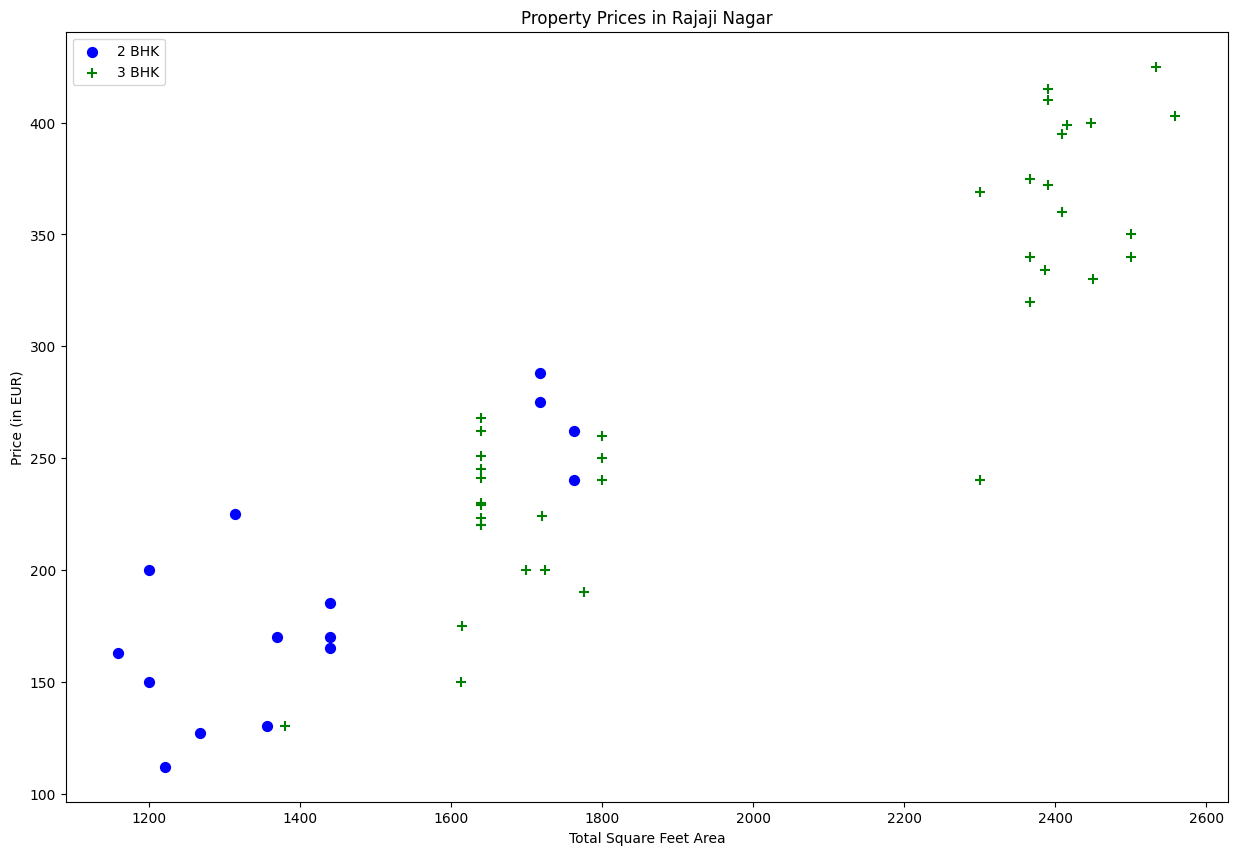

In [37]:
def plot_property_prices(df, location):
    bhk2_data = df[(df.location == location) & (df.bhk == 2)]
    bhk3_data = df[(df.location == location) & (df.bhk == 3)]
    
    # Set the figure size for better visibility
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    
    # Plot 2 BHK properties as blue scatter points
    plt.scatter(bhk2_data.total_sqft, bhk2_data.price, color='blue', s=50)
    
    # Plot 3 BHK properties as green plus markers
    plt.scatter(bhk3_data.total_sqft, bhk3_data.price, marker='+', color='green', s=50)
    
    # Add labels and title to the plot
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (in EUR)")
    plt.title(f"Property Prices in {location}")
    
    # Display the legend with unique entries
    plt.legend(["2 BHK", "3 BHK"], loc='best')

    # Show the plot
    plt.show()

# Call the function for a specific location
plot_property_prices(df, "Rajaji Nagar")


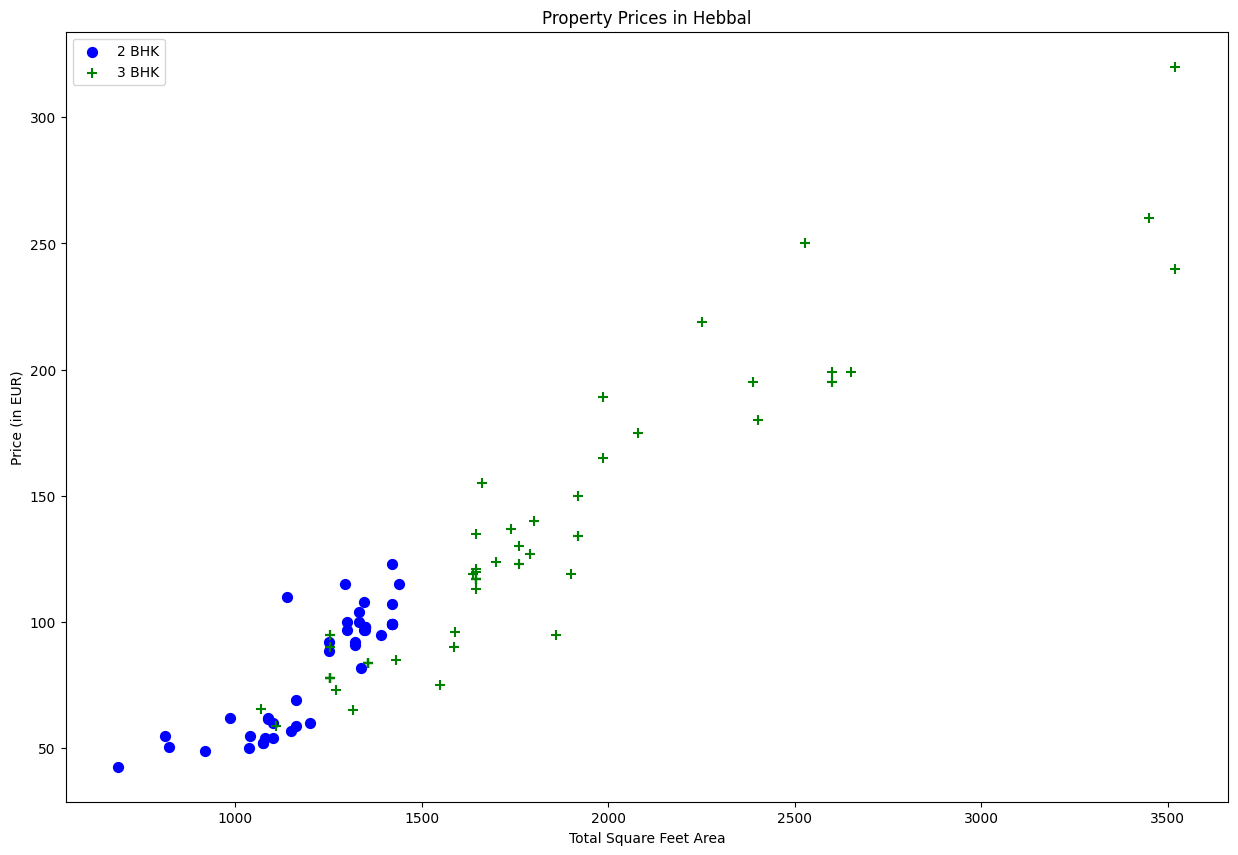

In [38]:
plot_property_prices(df, "Hebbal")

### **Removing Price Inconsistencies for Properties in Same Location**

To ensure data consistency, we need to remove instances where, for the same location, a property with more bedrooms (e.g., a 3-bedroom apartment) is priced lower than a property with fewer bedrooms (e.g., a 2-bedroom apartment), even if they have the same square footage. 

The process involves building a dictionary that stores the statistical information (mean, standard deviation, and count) for each bedroom category (`bhk`) in a given location. The structure would look like this:

```python
{
    '1' : {
        'mean': 4000,
        'std': 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std': 2300,
        'count': 22
    },
}


In [39]:
def remove_bhk_outliers(df):
    exclude_indices = []  # Use a list to store the indices of outliers
    
    # Group by location to process each location separately
    for location, location_df in df.groupby('location'):
        # Create a dictionary to store mean, std, and count for each BHK
        bhk_stats = {
            bhk: {
                'mean': location_df[location_df.bhk == bhk].price_per_sqft.mean(),
                'std': location_df[location_df.bhk == bhk].price_per_sqft.std(),
                'count': location_df[location_df.bhk == bhk].shape[0]
            }
            for bhk in location_df.bhk.unique()
        }

        # Identify outliers: check if price_per_sqft of current BHK is less than the mean of the previous BHK
        for bhk, bhk_df in location_df.groupby('bhk'):
            if bhk > 1:  # Check only for BHK greater than 1
                prev_bhk_stats = bhk_stats.get(bhk - 1)
                if prev_bhk_stats and prev_bhk_stats['count'] > 5:  # Ensure the previous BHK group has enough data
                    prev_bhk_mean = prev_bhk_stats['mean']
                    # Append outlier indices (properties that have a lower price_per_sqft than the previous BHK's mean)
                    outliers = bhk_df[bhk_df.price_per_sqft < prev_bhk_mean].index
                    exclude_indices.extend(outliers)  # Extend the list with outliers

    # Remove the identified outliers
    return df.drop(exclude_indices, axis='index')

df = remove_bhk_outliers(df)
df.shape


(7365, 7)

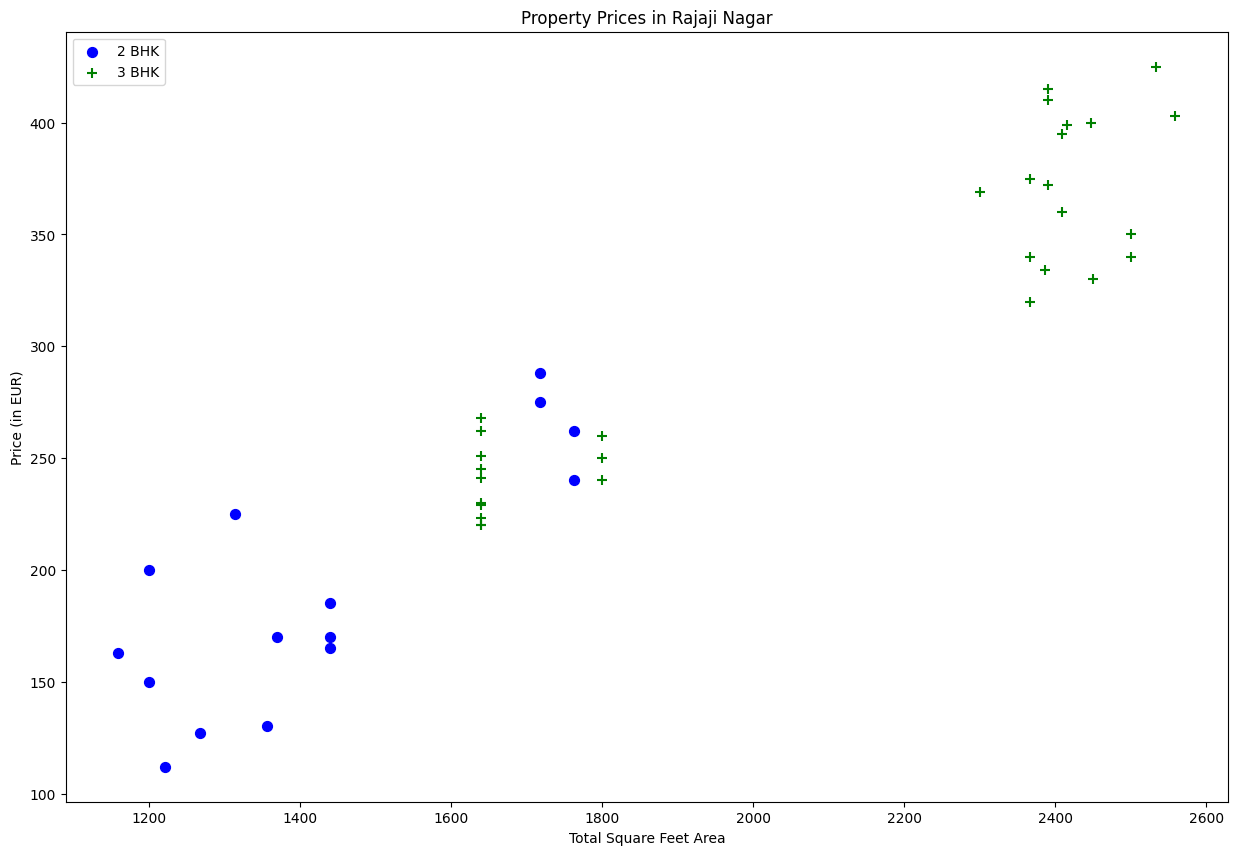

In [40]:
# Plot the property prices again after removing outliers
plot_property_prices(df, "Rajaji Nagar")


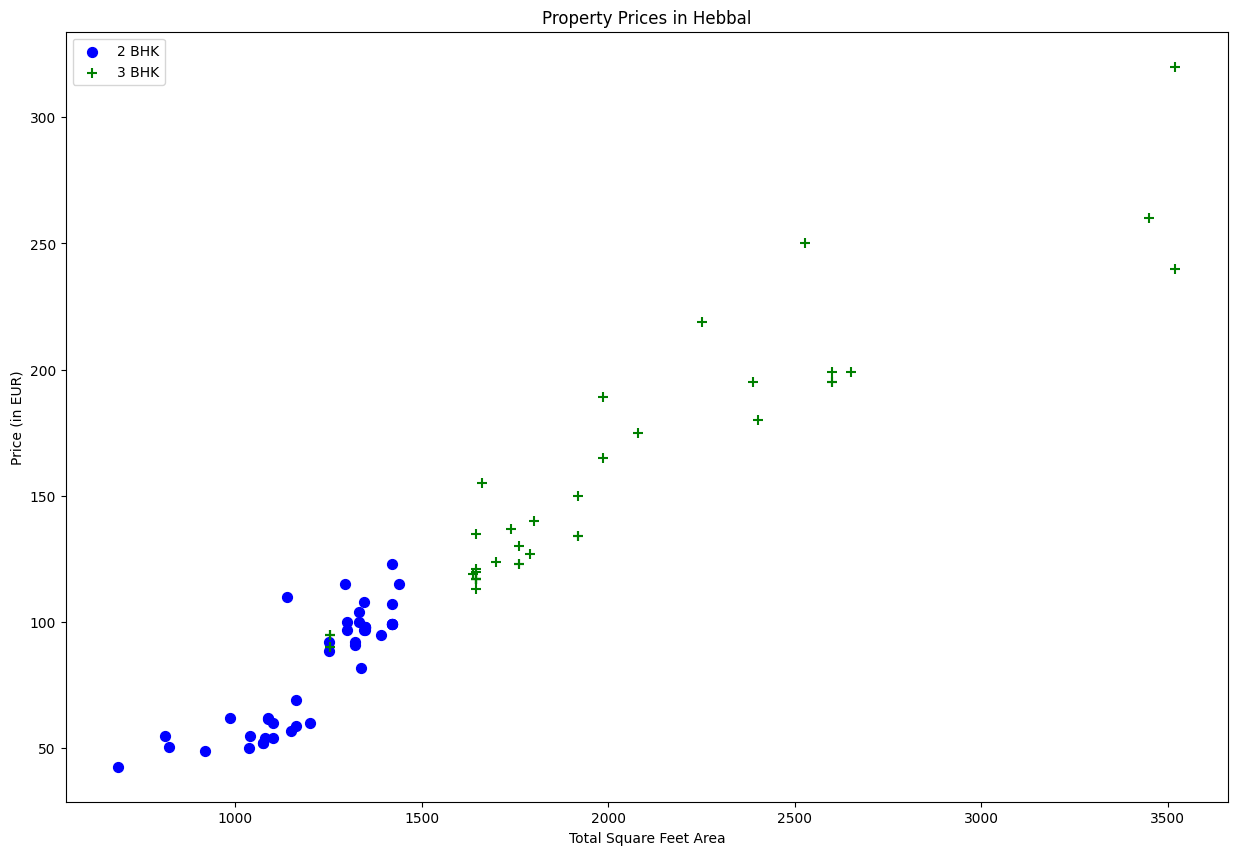

In [41]:
plot_property_prices(df, "Hebbal")

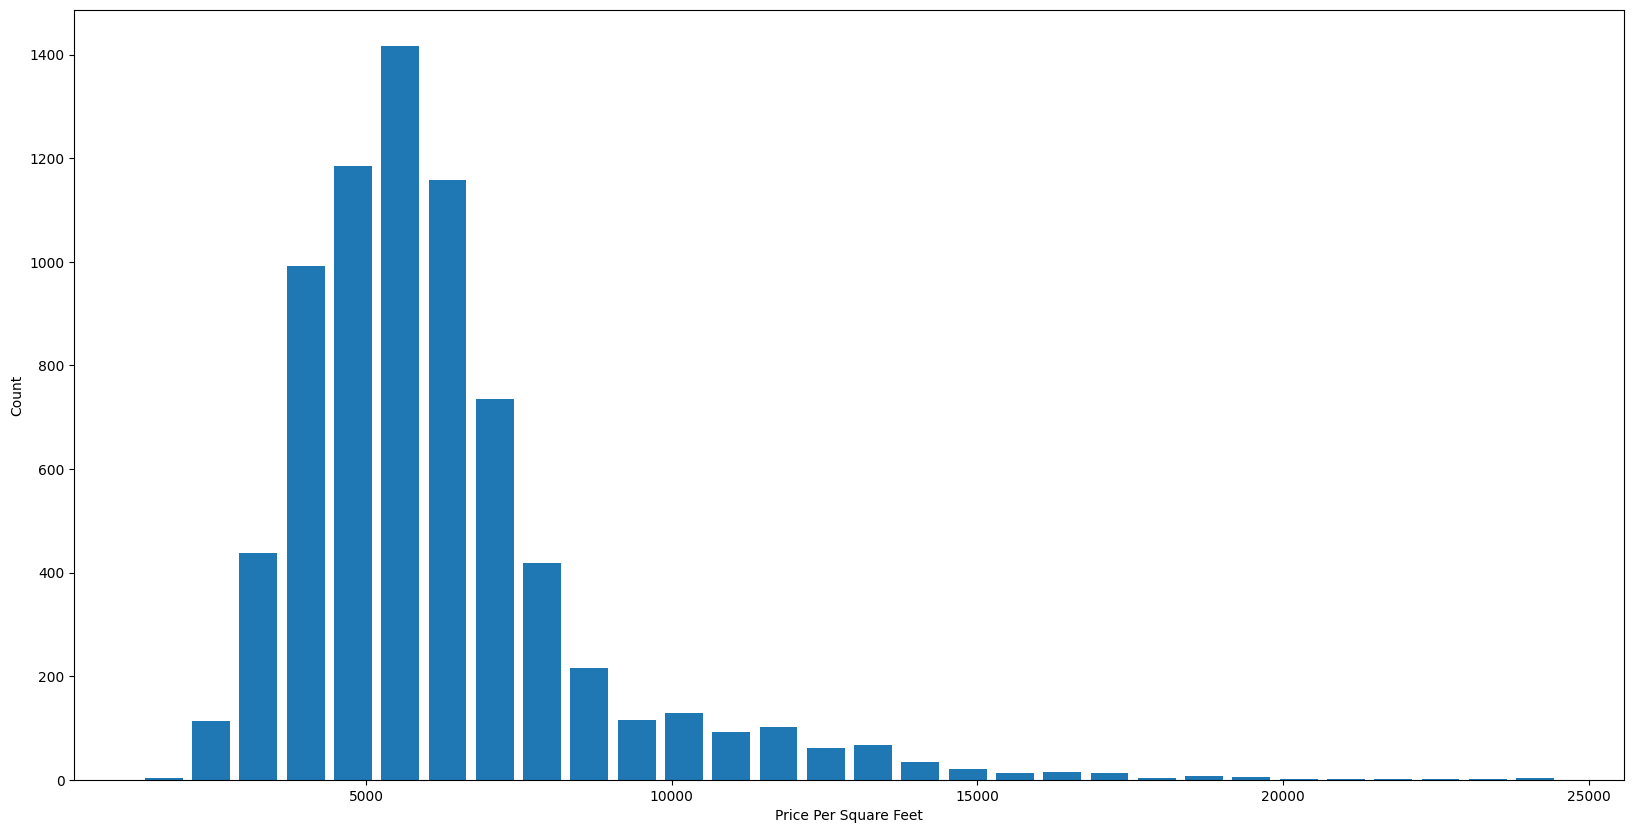

In [42]:
# Create a figure with the specified size
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the histogram
ax.hist(df.price_per_sqft, bins=30, rwidth=0.8)  # You can adjust the number of bins as needed

# Set the labels and title
ax.set_xlabel("Price Per Square Feet")
ax.set_ylabel("Count")

# Show the plot
plt.show()


<h2 style="color:lightblue">Outlier removal - bathroom feature</h2>

In [43]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

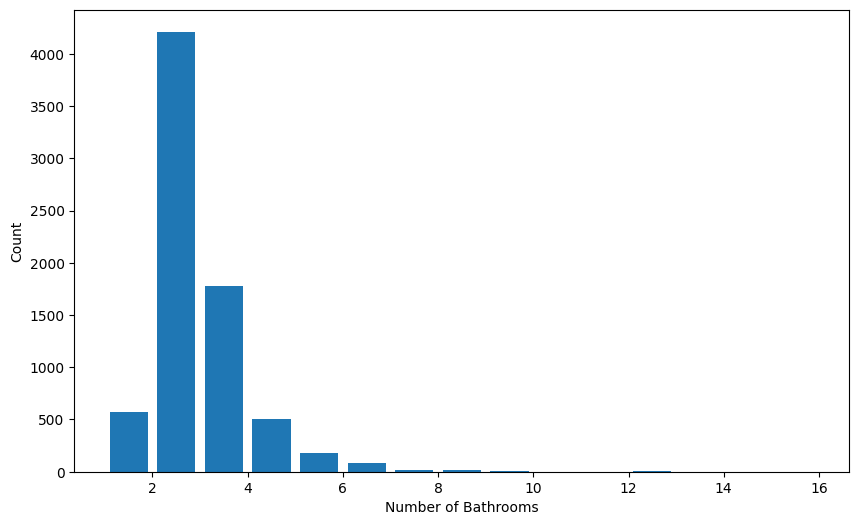

In [44]:
# Create a figure with the specified size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for the number of bathrooms
ax.hist(df.bath, bins=range(int(df.bath.min()), int(df.bath.max()) + 1), rwidth=0.8)

# Set the labels and title
ax.set_xlabel("Number of Bathrooms")
ax.set_ylabel("Count")

# Display the plot
plt.show()


In [45]:
# Display properties with more than 10 bathrooms
df[df.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5312,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8533,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8622,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9357,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9688,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


- So what we see is that we have unusual data where we have 2 more bathrooms than number of bedrooms 

In [46]:
df[df.bath>df.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5273,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6756,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8458,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


#### **According to the business manager, in a 4-bedroom house, having a bathroom in each bedroom plus one guest bathroom is acceptable, so the maximum number of bathrooms should be 5 (the number of bedrooms plus one). Any property with more than that would be classified as an outlier or data inconsistency and should be removed.**

In [47]:
df = df[df['bath'] < (df['bhk'] + 2)]
df.shape

(7286, 7)

In [48]:
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [49]:
# Drop the 'size' and 'price_per_sqft' columns
df = df.drop(['size','price_per_sqft'],axis='columns')
df.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style="color:lightblue">ONE HOT ENCODING - LOCATION</h2>

- we have to convert text to number and for that we are using one hot encoding

In [50]:
dummies = pd.get_dummies(df['location'])
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
df = df.join(dummies.drop('other', axis='columns'))
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
df = df.loc[:, df.columns != 'location']
df.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style = "color:lightblue">BUILDING A MODEL</h2>

In [53]:
df.shape

(7286, 244)

In [54]:
X = df.iloc[:, df.columns != 'price']
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
X.shape

(7286, 243)

In [56]:
y = df['price']
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [57]:
len(y)

7286

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model = LinearRegression()
model.fit(X_train, y_train)

print("Train score:", model.score(X_train, y_train))  # Check training performance
print("Test score:", model.score(X_test, y_test))    # Check test performance


Train score: 0.8517626835787193
Test score: 0.8529902094103546


In [59]:
# we use ShuffleSplit to randomize the data and split it into training and test sets and cross-validate the model
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.75697432, 0.85519762, 0.85024241, 0.88528941, 0.86350921])

- After 5 iterations, most of the time we achieve a score above 80%, which is promising. However, we'd like to explore additional regression algorithms to see if we can further improve the score. To do this, we'll employ GridSearchCV for optimization.

<h2 style="color:lightblue">GRID SEARCH - FINDING THE BEST MODEL</h2>

In [64]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]  # Using fit_intercept instead of normalize
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],  # Corrected syntax
                'splitter': ['best', 'random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])



In [65]:
find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.842425,{'fit_intercept': False}
1,lasso,0.693697,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.736695,"{'criterion': 'squared_error', 'splitter': 'be..."


- From the results above, it is evident that LinearRegression achieves the highest score, making it the optimal choice for this task. Therefore, we will proceed with this model.

<h2 style="color:lightblue">TESTING THE MODEL</h2>

In [74]:
def predict_price(location, sqft, bath, bhk, model):
    # Create an array of zeros with the same length as the number of columns in X
    features = np.zeros(len(X.columns))
    
    # Set the known features
    features[0] = sqft
    features[1] = bath
    features[2] = bhk
    
    # Check if the location is present in the columns
    if location in X.columns:
        # Find the index of the location and set the corresponding feature value to 1
        loc_index = np.where(X.columns == location)[0][0]
        features[loc_index] = 1
    else:
        # If location is not in columns, set it to 0 (or handle it however you'd like)
        pass

    # Use the model to predict the price with the prepared feature vector
    return model.predict([features])[0]


In [75]:
predict_price('1st Phase JP Nagar',1000, 2, 2, model)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.69801530127265

In [76]:
predict_price('1st Phase JP Nagar',1000, 3, 3, model)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


87.791398929368

In [78]:
predict_price('Indira Nagar',1000, 2, 2,model)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


181.28737269597596

In [79]:
predict_price('Indira Nagar',1000, 3, 3, model)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


185.38075632407126

<h2 style = "color:lightblue">EXPORT THE MODEL</h2>

In [81]:
with open('house_prices_model.pickle','wb') as f:
    pickle.dump(model,f)

<h3 style="color:lightblue">Save the location and column details to a file for future use in the prediction application.</h3>

In [83]:
# Create a dictionary with the column names in lowercase
columns = {
    'data_columns': list(map(str.lower, X.columns))
}

# Save the dictionary as a JSON file
json.dump(columns, open("columns.json", "w"))